In [119]:
import pandas as pd
import numpy as np
import statistics
import matplotlib
from matplotlib import pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import torch
import sklearn
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
#from descriptastorus.descriptors import rdDescriptors

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

# Data reading

In [121]:
data_path = 'z_ML datasets__/'

FreeSolve_df = pd.read_csv(data_path + 'SAMPL.csv')

FreeSolve_df.head(1)

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625


In [122]:
# FreeSolve_df.expt.hist(figsize = (10,7), bins=100)

In [123]:
seed = 1

FreeSolve_df.sample(frac=.8, random_state = seed).head()

,iupac,smiles,expt,calc
179,"1,1,1-trimethoxyethane",CC(OC)(OC)OC,-4.42,-3.700
533,1-phenylethanone,CC(=O)c1ccccc1,-4.58,-5.078
526,methanethiol,CS,-1.20,-0.273
260,ethylene,C=C,1.28,2.328
82,phenylmethanol,c1ccc(cc1)CO,-6.62,-5.133


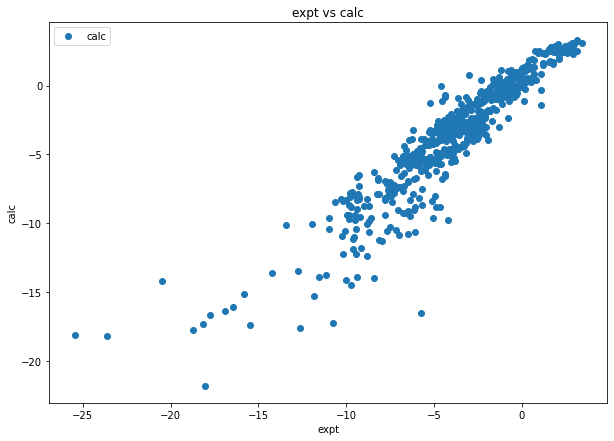

In [124]:
# plot below is taken from dataset creator article; it reflects general form of dependence between predicted value and calculated

FreeSolve_df.plot(x='expt', y='calc', style='o')  

plt.title('expt vs calc')  

plt.xlabel('expt');  plt.ylabel('calc')

plt.show()

# Data processing

Filling train/test sets with certain chemical features extracted from SMILES with RDkit module:

,iupac,smiles,expt,calc,ROMol,n_Atoms,Molec_weight,LogP,AP,HA,MaxCharge_abs,MaxCharge
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,,13,179.219,1.397,1,0.076923,0.496768,0.252836

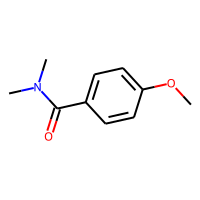

In [125]:
# before saving the file you should drop ROMol column "FreeSolve_df = FreeSolve_df.drop(['%name'], axis=1)"

PandasTools.AddMoleculeColumnToFrame(FreeSolve_df, smilesCol='smiles')

FreeSolve_df['n_Atoms'] = FreeSolve_df['ROMol'].map(lambda x: x.GetNumAtoms())
 
FreeSolve_df['Molec_weight'] = [Descriptors.MolWt(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['LogP'] = [Chem.Crippen.MolLogP(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['AP'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['HA'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumHeavyAtoms() for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge_abs'] = [Descriptors.MaxAbsPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge'] = [Descriptors.MaxPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

#FreeSolve_df = FreeSolve_df.drop(['FP_1'], axis=1)

FreeSolve_df.head(1)

In [126]:
train_df = FreeSolve_df.sample(frac=.8, random_state = seed)
test_df = FreeSolve_df[~FreeSolve_df.index.isin(train_df.index)]

print('Train set shape:', train_df.shape, '\n', 'Test set shape:', test_df.shape)

Train set shape: (514, 12) 
 Test set shape: (128, 12)


In [127]:
target = 'calc'

dim = 6

signs = ['MaxCharge_abs', 'MaxCharge', 'LogP', 'Molec_weight', 'HA', 'AP']

train_y = np.asanyarray(train_df[[target]]).astype(np.float32)
train_x = np.asanyarray(train_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5]]]).astype(np.float32)

train_x = torch.from_numpy(train_x.reshape(train_x.shape[0], dim))
train_y = torch.from_numpy(train_y.reshape(train_y.shape[0], 1))

test_y = np.asanyarray(test_df[[target]]).astype(np.float32)
test_x = np.asanyarray(test_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5]]]).astype(np.float32)

test_x = torch.from_numpy(test_x.reshape(test_x.shape[0], dim))
test_y = torch.from_numpy(test_y.reshape(test_y.shape[0], 1))

# Random forest

In [128]:
type1 = 'Random Forest'

RF_Reg = RandomForestRegressor(random_state=seed)  #(n_estimators = 100, , min_samples_split=10, min_samples_leaf=20)

RF_Reg.fit(train_x, train_y.numpy().ravel())

CV_RF = cross_validate(RF_Reg, train_x, train_y.numpy().ravel(), cv=5)

CV_RF['test_score'] = np.around(CV_RF['test_score'], 3)

CV_RF = np.mean(CV_RF['test_score'])
#sorted(cv_results.keys())
print('Cross-val general:', CV_RF)

Cross-val general: 0.8032


In [129]:
RF_Reg = RF_Reg.predict(test_x)

accuracy_RF = sklearn.metrics.r2_score(test_y.detach().numpy(), RF_Reg) 

accuracy_RF = (round(accuracy_RF*100, 3))

print("Accuracy: %a"%accuracy_RF + "%") 

Accuracy: 87.17%


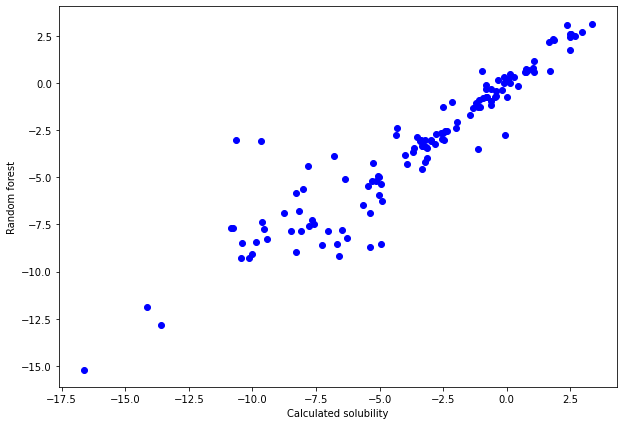

In [130]:
plt.plot(test_y.numpy(), RF_Reg, 'o', c = 'b', label = 'Default distribution')
    
plt.ylabel('Random forest');  
plt.xlabel('Calculated solubility');
    
#plt.legend(loc = 'upper right')

# Gradient Boosting Regression

In [131]:
type2 = 'Gradient Boosting (unvalidated)'

GB_Reg2 = GradientBoostingRegressor(random_state=seed)

GB_Reg2.fit(train_x, train_y.numpy().ravel())

CV_GB2 = cross_validate(GB_Reg2, train_x, train_y.numpy().ravel(), cv=5)

CV_GB2['test_score'] = np.around(CV_GB2['test_score'], 3)

CV_GB2 = np.mean(CV_GB2['test_score'])
#sorted(cv_results.keys())
print('Cross-val general:', CV_GB2)

Cross-val general: 0.8088000000000001


In [132]:
GB_Reg2 = GB_Reg2.predict(test_x)

accuracy_GB2 = sklearn.metrics.r2_score(test_y.detach().numpy(), GB_Reg2) 

accuracy_GB2 = (round(accuracy_GB2*100, 3))

print("Accuracy: %a"%accuracy_GB2 + "%") 

Accuracy: 84.241%


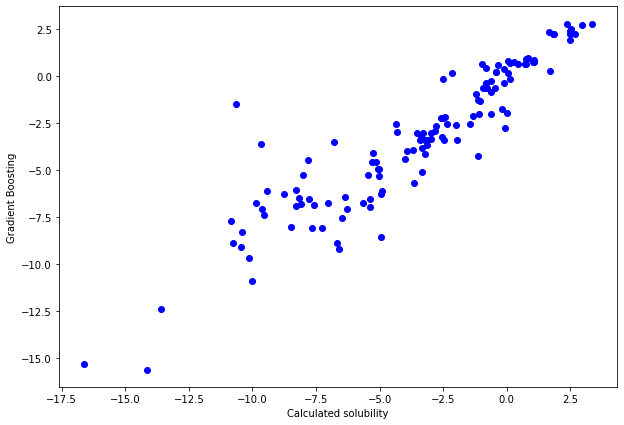

In [133]:
plt.plot(test_y.numpy(), GB_Reg2, 'o', c = 'b')  

plt.ylabel('Gradient Boosting');  
plt.xlabel('Calculated solubility');
    
#plt.legend(loc = 'upper right')

# Bagging Regressor

In [134]:
type3 = 'Bagging'

Bag_Reg = BaggingRegressor(random_state=seed)  #(n_estimators=100, max_samples=15, random_state=seed, warm_start=True)

Bag_Reg.fit(train_x, train_y.numpy().ravel())

CV_Bag = cross_validate(Bag_Reg, train_x, train_y.numpy().ravel(), cv=5)

CV_Bag['test_score'] = np.around(CV_Bag['test_score'], 3)

CV_Bag = np.mean(CV_Bag['test_score'])
#sorted(cv_results.keys())
print('Cross-val general:', CV_Bag)

Cross-val general: 0.8108000000000001


In [135]:
Bag_Reg = Bag_Reg.predict(test_x)

accuracy_Bag = sklearn.metrics.r2_score(test_y.detach().numpy(), Bag_Reg) 

accuracy_Bag=(round(accuracy_Bag*100, 3))

print("Accuracy: %a"%accuracy_Bag + "%") 

Accuracy: 83.383%


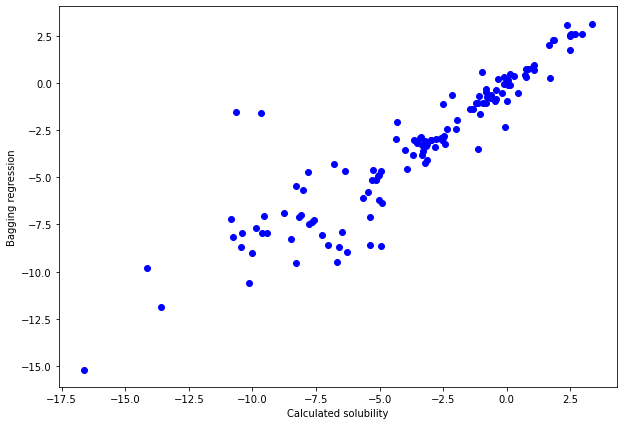

In [136]:
plt.plot(test_y.numpy(), Bag_Reg, 'o', c = 'b')  

plt.ylabel('Bagging regression');  
plt.xlabel('Calculated solubility');
    
#plt.legend(loc = 'upper right')

# Neural network

In [137]:
type4 = 'Neural network'

# attribute "dim" reflects number of input features obtained from smiles (we declare it before in "Data processing" unit)

class Neural_net(torch.nn.Module):                
    
    def __init__(self, n_hide_n):                       
        
        super(Neural_net, self).__init__()                
        
        self.fc1 = torch.nn.Linear(dim, n_hide_n)          
        
        self.act1 = torch.nn.Tanh() 
        
        self.fc2 = torch.nn.Linear(n_hide_n, n_hide_n)
                
        self.act2 = torch.nn.Tanh() 
        
        self.fc3 = torch.nn.Linear(n_hide_n, 1)

    def forward(self, x):
        
        x = self.fc1(x)
        
        x = self.act1(x)
        
        x = self.fc2(x)
        
        x = self.act2(x)
        
        x = self.fc3(x)
        
        return x

In [138]:
neurons = 19

network = Neural_net(neurons)

def Predict(net, x, y):
    
    y_pred = net.forward(x)
      
    plt.plot(y.numpy(), y_pred.data.numpy(), 'o', c = 'r')
    
    plt.ylabel('Network prediction')  
    
    plt.xlabel('Calculated solubility')
    
    #plt.legend(loc = 'upper right')
       
    
def loss(pred, true):   # MSE
    
    sq = (pred-true)**2    

    return sq.mean()

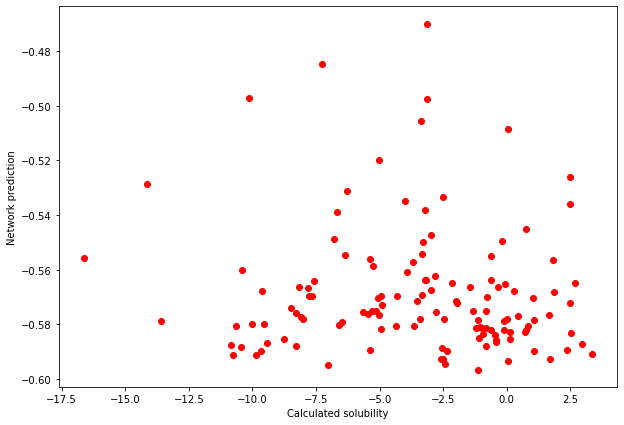

In [139]:
Predict(network, test_x, test_y)

In [140]:
epoch = 10000

optimizer = torch.optim.Adamax(network.parameters(), lr=0.0007)

for e in range(epoch):
    
    optimizer.zero_grad() 

    y_pred = network.forward(train_x)
    
    loss_val = loss(y_pred, train_y)

    loss_val.backward()
    
    optimizer.step()
    
    if not e % (epoch//5):
        print(loss_val)

tensor(26.1839, grad_fn=<MeanBackward0>)
tensor(3.0814, grad_fn=<MeanBackward0>)
tensor(2.2933, grad_fn=<MeanBackward0>)
tensor(1.6723, grad_fn=<MeanBackward0>)
tensor(1.2498, grad_fn=<MeanBackward0>)


In [141]:
# we call .detach() to "detach(delete)" the computational graphs layer (that the tensors' feature, which is unlike from ndarray)     
accuracy = sklearn.metrics.r2_score(train_y.detach().numpy(), y_pred.detach().numpy())  
accuracy = round(accuracy*100, 3)
print("Accuracy: %a"%(accuracy) + "%") 

Accuracy: 94.802%


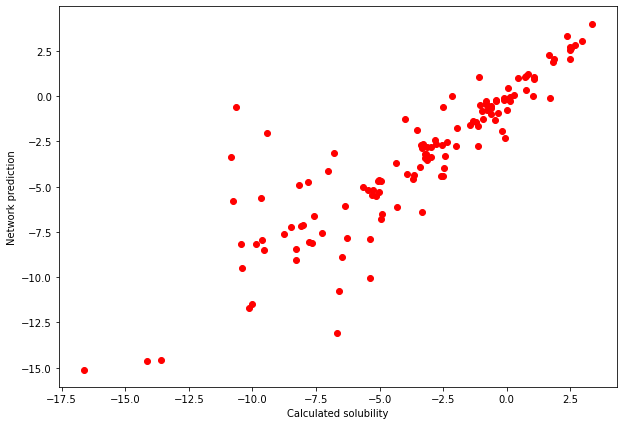

In [142]:
Predict(network, test_x, test_y)

# Models scores comparison

In [143]:
regscore_df = pd.DataFrame({'Regression type': [type1, type2, type3, type4], 'Accuracy, %': [accuracy_RF, accuracy_GB2, accuracy_Bag, accuracy]})

regscore_df

,Regression type,"Accuracy, %"
0,Random Forest,87.170
1,Gradient Boosting (unvalidated),84.241
2,Bagging,83.383
3,Neural network,94.802
